#### Script for making mean yearly wind direction and speed TIF files w/o aggregation

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from pathlib import Path

def calculate_aggregations_and_save_tif(input_nc_file, pressure_level=1000, min_year=None, max_year=None, year_interval=None):
    """
    Calculate wind speed and direction averages at a specified pressure level, and save the results into new GeoTIFF files.
    
    Parameters:
    input_nc_file (str): Path to NetCDF file with wind data.
    pressure_level (int): Pressure level to analyze (default is 1000 mb).
    min_year (int): Optional, minimum year for analysis.
    max_year (int): Optional, maximum year for analysis.
    year_interval (int): Optional, number of years for grouping (e.g., 5 for 5-year intervals, 10 for 10-year intervals). 
                         If None, aggregate over the full available year range.
    
    Output:
    GeoTIFF files containing aggregated results for wind speed and wind direction, named based on the time period.
    """

    # Load the dataset
    ds = xr.open_dataset(input_nc_file, engine='netcdf4')

    # Ensure the 'date' coordinate is in the correct format
    if not np.issubdtype(ds['date'].dtype, np.datetime64):
        ds['date'] = pd.to_datetime(ds['date'].values, format='%Y%m%d')

    # Check if the specified pressure level exists in the dataset
    if 'pressure_level' in ds.coords and pressure_level in ds['pressure_level'].values:
        # Select the specified pressure level
        ds = ds.sel(pressure_level=pressure_level)
    else:
        raise ValueError(f"Pressure level {pressure_level} mb not found in the dataset.")

    # Check if 'u' and 'v' components exist in the dataset
    if 'u' not in ds or 'v' not in ds:
        raise KeyError(f"The dataset does not contain the required 'u' and 'v' wind components.")

    # Calculate wind speed (m/s) from u and v components
    ds['wind_speed'] = np.sqrt(ds['u']**2 + ds['v']**2)

    # Calculate wind direction in degrees, following meteorological convention (0° = North)
    ds['wind_dir'] = (270 - np.rad2deg(np.arctan2(ds['v'], ds['u']))) % 360

    # Determine the available years in the dataset
    years = ds['date'].dt.year.values
    available_min_year = years.min()
    available_max_year = years.max()

    # Set default min_year and max_year if not provided
    start_year = min_year if min_year else available_min_year
    end_year = max_year if max_year else available_max_year

    # Check for conflicts in year range
    if start_year > end_year:
        raise ValueError(f"min_year ({start_year}) cannot be greater than max_year ({end_year}).")
    
    if start_year < available_min_year or end_year > available_max_year:
        raise ValueError(f"The selected year range ({start_year}-{end_year}) is outside the available data range ({available_min_year}-{available_max_year}).")

    # Check if year_interval is larger than the available range
    if year_interval and year_interval > (end_year - start_year + 1):
        print(f"Year interval ({year_interval}) is larger than the available year range ({start_year}-{end_year}). Processing the entire range as a single block.")
        year_interval = None  # Set to None to process as a single block

    input_nc_path = Path(input_nc_file)
    output_dir = input_nc_path.parent  # Output in the same directory as the input
    base_output_file_name = f"{input_nc_path.stem}_{pressure_level}mb"

    # Handle year intervals
    if year_interval is None:
        # Aggregate over the full available year range
        data_interval = ds.sel(date=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
        interval_mean = data_interval.mean(dim='date', skipna=True)  # Handle NaN values
        output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}"
        process_aggregation_and_save_as_tif(interval_mean, output_file)
    else:
        # Subdivide into year intervals and process each group
        process_by_year_interval(ds, start_year, end_year, year_interval, output_dir, base_output_file_name)

def process_by_year_interval(ds, start_year, end_year, year_interval, output_dir, base_output_file_name):
    """
    Process data in blocks based on the specified year interval.
    """
    for year_start in range(start_year, end_year + 1, year_interval):
        year_end = min(year_start + year_interval - 1, end_year)
        year_label = f"{year_start}_{year_end}"
        
        # Select the data within the year range
        data_interval = ds.sel(date=slice(f"{year_start}-01-01", f"{year_end}-12-31"))

        # Check if the selected dataset is empty
        if data_interval.date.size == 0:
            print(f"No data available for the interval {year_label}. Skipping...")
            continue
        
        # Aggregate over the time dimension within the interval
        interval_mean = data_interval.mean(dim='date', skipna=True)

        # Generate output file name and save as GeoTIFF
        output_file = output_dir / f"{base_output_file_name}_{year_label}"
        process_aggregation_and_save_as_tif(interval_mean, output_file)

def process_aggregation_and_save_as_tif(aggregated, output_file):
    """
    Process aggregated wind speed and direction, then save as GeoTIFF files using rasterio.
    
    Parameters:
    aggregated (xarray.Dataset): Aggregated dataset (e.g., for a year interval or full range).
    output_file (Path): Output file name without extension.
    """

    # Extract necessary data
    avg_wind_speed = aggregated['wind_speed'].squeeze().values  # Ensure it is 2D (lat, lon)
    avg_wind_dir = aggregated['wind_dir'].squeeze().values  # Ensure it is 2D (lat, lon)
    latitudes = aggregated['latitude'].values
    longitudes = aggregated['longitude'].values

    # Check if the dataset is valid and has the correct shape
    if avg_wind_speed.ndim != 2 or avg_wind_speed.size == 0:
        print(f"Invalid dataset for {output_file}. Skipping...")
        return

    # Define the raster transformation (assuming regular grid with constant spacing)
    transform = from_origin(np.min(longitudes), np.max(latitudes), np.abs(longitudes[1] - longitudes[0]), np.abs(latitudes[1] - latitudes[0]))

    # Define metadata for GeoTIFF files
    meta = {
        'driver': 'GTiff',
        'height': avg_wind_speed.shape[0],  # Number of latitudes
        'width': avg_wind_speed.shape[1],   # Number of longitudes
        'count': 1,                         # Single band (wind speed or direction)
        'dtype': 'float32',
        'crs': 'EPSG:4326',                 # Coordinate reference system (WGS84)
        'transform': transform
    }

    # Save the wind speed raster
    wind_speed_tif = f"{output_file}_wind_speed.tif"
    with rasterio.open(wind_speed_tif, 'w', **meta) as dst:
        dst.write(avg_wind_speed, 1)  # Writing the aggregated wind speed

    print(f"Wind speed GeoTIFF saved to {wind_speed_tif}")

    # Save the wind direction raster
    wind_dir_tif = f"{output_file}_wind_dir.tif"
    with rasterio.open(wind_dir_tif, 'w', **meta) as dst:
        dst.write(avg_wind_dir, 1)  # Writing the averaged wind direction

    print(f"Wind direction GeoTIFF saved to {wind_dir_tif}")

# Example usage:
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0.nc"
calculate_aggregations_and_save_tif(input_nc_file, pressure_level=250, year_interval=10)


Wind speed GeoTIFF saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_250mb_1940_1949_wind_speed.tif
Wind direction GeoTIFF saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_250mb_1940_1949_wind_dir.tif
Wind speed GeoTIFF saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_250mb_1950_1959_wind_speed.tif
Wind direction GeoTIFF saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_250mb_1950_1959_wind_dir.tif
Wind speed GeoTIFF saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_250mb_1960_1969_wind_speed.tif
Wind direction GeoTIFF saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_250mb_1960_1969_wind_dir.tif
Wind speed GeoTIFF saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_250mb_1970_1979_wind_speed.tif
Wind direction GeoTIFF saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly

#### Script for making neab wind direction TIF (wind direction) files per aggregation level 

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
from pathlib import Path

def calculate_aggregations_and_save_tif(input_nc_file, aggregation="yearly", pressure_level=1000, min_year=None, max_year=None, year_interval=None, period=None):
    
    """
    This script processes ERA5 data to generate wind direction averages for yearly, seasonal, or quarterly periods. 
    It allows the user to specify a range of years and intervals, and supports processing exact seasons (e.g., DJF for winter) 
    or quarters (e.g., Q1 for January-March). Output is saved as GeoTIFF files.

    Parameters:
    - input_nc_file: Path to the input NetCDF file containing wind data.
    - aggregation: Defines the type of aggregation (yearly, seasonal, or quarterly).
    - pressure_level: The pressure level to analyze (default is 1000 mb).
    - min_year, max_year: The start and end year for analysis.
    - year_interval: The interval of years to group data (e.g., 5-year blocks).
    - period: Defines the season (e.g., 'DJF') or quarter (e.g., 'Q1') for aggregation.

    Output:
    GeoTIFF files containing aggregated wind direction data for the specified periods and intervals.
    """
    
    ds = xr.open_dataset(input_nc_file, engine='netcdf4')

    # Ensure date format is correct
    if not np.issubdtype(ds['date'].dtype, np.datetime64):
        ds['date'] = np.array(pd.to_datetime(ds['date'].values, format='%Y%m%d'))

    # Select the specified pressure level
    if 'pressure_level' in ds.coords and pressure_level in ds['pressure_level'].values:
        ds = ds.sel(pressure_level=pressure_level)
    else:
        raise ValueError(f"Pressure level {pressure_level} mb not found in the dataset.")

    # Ensure required wind components are present
    if 'u' not in ds or 'v' not in ds:
        raise KeyError("The dataset does not contain the required 'u' and 'v' wind components.")

    # Calculate wind direction in degrees (meteorological convention)
    ds['wind_dir'] = (270 - np.rad2deg(np.arctan2(ds['v'], ds['u']))) % 360

    # Validate time range and year interval
    years = ds['date'].dt.year.values
    available_min_year = years.min()
    available_max_year = years.max()

    start_year = min_year if min_year else available_min_year
    end_year = max_year if max_year else available_max_year

    if start_year > end_year:
        raise ValueError(f"min_year ({start_year}) cannot be greater than max_year ({end_year}).")

    if start_year < available_min_year or end_year > available_max_year:
        raise ValueError(f"The selected year range ({start_year}-{end_year}) is outside the available data range ({available_min_year}-{available_max_year}).")

    if year_interval and year_interval > (end_year - start_year + 1):
        year_interval = None

    # Define output directory and base filename
    input_nc_path = Path(input_nc_file)
    output_dir = input_nc_path.parent
    base_output_file_name = f"{input_nc_path.stem}_{pressure_level}mb"

    # Define seasons and quarters
    periods = {
        'DJF': ([12, 1, 2], 'winter'),
        'MAM': ([3, 4, 5], 'spring'),
        'JJA': ([6, 7, 8], 'summer'),
        'SON': ([9, 10, 11], 'fall'),
        'Q1': ([1, 2, 3], 'Q1'),
        'Q2': ([4, 5, 6], 'Q2'),
        'Q3': ([7, 8, 9], 'Q3'),
        'Q4': ([10, 11, 12], 'Q4')
    }

    # Sanity check for a valid period declaration
    if period and period not in periods:
        raise ValueError(f"Invalid period '{period}'. Valid options: {list(periods.keys())}.")

    # Process data based on the aggregation type
    if year_interval is None:
        if aggregation == "yearly":
            process_yearly_aggregation(ds, start_year, end_year, output_dir, base_output_file_name)
        elif aggregation in ["seasonal", "quarterly"]:
            process_period_aggregation(ds, start_year, end_year, periods, output_dir, base_output_file_name, period)
    else:
        for year_start in range(start_year, end_year + 1, year_interval):
            year_end = min(year_start + year_interval - 1, end_year)
            if aggregation == "yearly":
                process_yearly_aggregation(ds, year_start, year_end, output_dir, base_output_file_name)
            elif aggregation in ["seasonal", "quarterly"]:
                process_period_aggregation(ds, year_start, year_end, periods, output_dir, base_output_file_name, period)

# Process yearly aggregation for the given year range
def process_yearly_aggregation(ds, start_year, end_year, output_dir, base_output_file_name):
    # Average wind direction for the given year range
    data_interval = ds.sel(date=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
    yearly_mean = data_interval.mean(dim='date', skipna=True)
    output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}_yearly"

    print(f"Processing yearly data for {start_year}-{end_year} and saving to {output_file} ...")

    process_aggregation_and_save_as_tif(yearly_mean, output_file)

# Process seasonal or quarterly aggregation for the given year range
def process_period_aggregation(ds, start_year, end_year, periods, output_dir, base_output_file_name, period):
    months, label = periods[period]
    data_interval = ds.sel(date=slice(f"{start_year}-01-01", f"{end_year}-12-31"))

    # Select data for the specified period (season/quarter)
    period_data = data_interval.sel(date=data_interval['date'].dt.month.isin(months)).mean(dim='date', skipna=True)
    
    # Check if valid wind direction data exists
    if 'wind_dir' not in period_data or period_data['wind_dir'].size == 0:
        raise ValueError(f"No valid data found for the period: {label} in {start_year}-{end_year}.")

    # Save the result to a GeoTIFF
    output_file = output_dir / f"{base_output_file_name}_{start_year}_{end_year}_{label}"

    print(f"Processing {label} data for {start_year}-{end_year} and saving to {output_file} ...")

    process_aggregation_and_save_as_tif(period_data, output_file)

# Process aggregated data and save as GeoTIFF
def process_aggregation_and_save_as_tif(aggregated, output_file):
    avg_wind_dir = aggregated['wind_dir'].squeeze().values
    latitudes = aggregated['latitude'].values
    longitudes = aggregated['longitude'].values

    # Check if the data is valid before saving
    if avg_wind_dir.ndim != 2 or avg_wind_dir.size == 0:
        raise ValueError(f"Invalid dataset for {output_file}. Skipping...")

    transform = from_origin(np.min(longitudes), np.max(latitudes), np.abs(longitudes[1] - longitudes[0]), np.abs(latitudes[1] - latitudes[0]))

    meta = {
        'driver': 'GTiff',
        'height': avg_wind_dir.shape[0],
        'width': avg_wind_dir.shape[1],
        'count': 1,
        'dtype': 'float32',
        'crs': 'EPSG:4326',
        'transform': transform
    }

    wind_dir_tif = f"{output_file}_wind_dir.tif"
    with rasterio.open(wind_dir_tif, 'w', **meta) as dst:
        dst.write(avg_wind_dir, 1)

# Example usage:
input_nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0.nc"
calculate_aggregations_and_save_tif(input_nc_file, aggregation="seasonal", pressure_level=500,  year_interval=5, period='DJF')

Processing winter data for 1940-1944 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_500mb_1940_1944_winter ...
Processing winter data for 1945-1949 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_500mb_1945_1949_winter ...
Processing winter data for 1950-1954 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_500mb_1950_1954_winter ...
Processing winter data for 1955-1959 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_500mb_1955_1959_winter ...
Processing winter data for 1960-1964 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_500mb_1960_1964_winter ...
Processing winter data for 1965-1969 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_multilevel\data_0_500mb_1965_1969_winter ...
Processing winter data for 1970-1974 and saving to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Monthly_mu

#### Script for temporal windrose chart after extracting pixel values using a quadrants of the bounding box

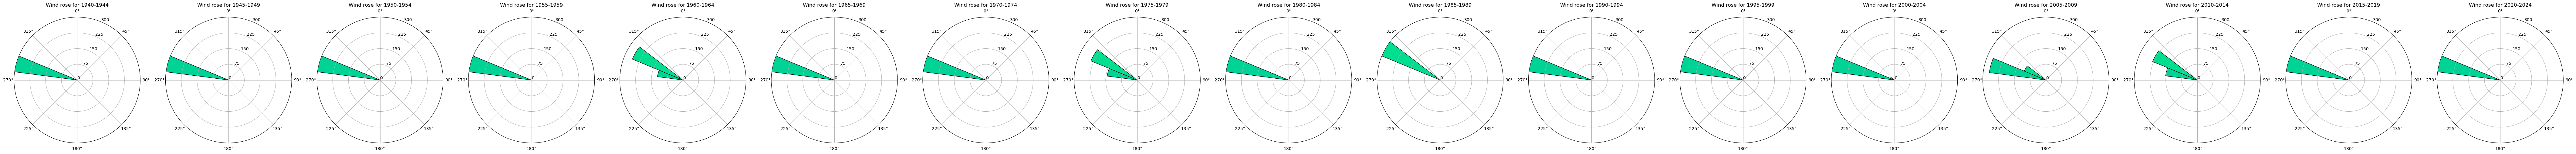

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Function to plot wind roses for each year interval from the input data
def plot_windrose_for_each_interval(excel_file, bin_size=30):

    """
    This script processes wind direction data from an Excel file, bins wind directions into specified intervals (e.g., 30 degrees),
    and generates wind rose plots for each time interval (e.g., yearly). The radial scale is standardized across all subplots, ensuring
    consistent concentric circles for visual comparison. Each wind rose is titled with the corresponding time interval.

    Parameters:
    - excel_file: Path to the input CSV file containing wind data. Mandatory columns: 'Value' (wind direction in degrees) and 'Year'.
    - bin_size: bin size for the windrose plot (default is 30 degrees).
    """

    # Load the data from the Excel file
    try:
        wind_data = pd.read_excel(excel_file, sheet_name="Quad-4")
    except Exception as e:
        raise ValueError(f"Error loading file: {e}")

    if 'Value' not in wind_data.columns or 'Year' not in wind_data.columns:
        raise ValueError("The input file must contain 'Value' and 'Year' columns.")

    # Define wind direction bins
    bins = np.arange(0, 361, bin_size)
    labels = [f"{i}-{i+bin_size}" for i in bins[:-1]]

    wind_data['Direction Bin'] = pd.cut(wind_data['Value'], bins=bins, labels=labels, include_lowest=True)

    # Group data by year and direction bin
    frequency_by_bin = wind_data.groupby(['Year', 'Direction Bin']).size().unstack(fill_value=0)

    if frequency_by_bin.empty:
        raise ValueError("No wind direction data found for the specified years.")  

    num_years = len(frequency_by_bin.index)
    if num_years == 0:
        raise ValueError("No valid year intervals found in the data.")

    fig, axes = plt.subplots(1, num_years, subplot_kw=dict(projection='polar'), figsize=(5 * num_years, 5))

    if num_years == 1:
        axes = [axes]

    angles = np.radians(np.arange(0, 360, bin_size))

    manual_rmax = 300

    # Set the accenet coloe of the bins, supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 
    # 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 
    # 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 
    # 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
    # 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
    # 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 
    # 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 
    # 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 
    # 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 
    # 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 
    # 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 
    # 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 
    # 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 
    # 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 
    # 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 
    # 'winter', 'winter_r'

    cmap = get_cmap('winter')
    colors = cmap(np.linspace(0, 1, len(angles)))

    for i, year_range in enumerate(frequency_by_bin.index):
        data = frequency_by_bin.loc[year_range]
        ax = axes[i]

        bars = ax.bar(angles, data, width=np.radians(bin_size), edgecolor='black', color=colors)
        ax.set_rmax(manual_rmax) 
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title(f"Wind rose for {year_range.replace('_', '-')}")

        radial_ticks = np.linspace(0, manual_rmax, num=5)
        ax.set_rticks(radial_ticks)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Integers on radial ticks

    plt.tight_layout()
    plt.show()

# Example usage
excel_file_path = r'C:\Users\Sunbeam\Desktop\Wind dir_500mb.xlsx'
plot_windrose_for_each_interval(excel_file_path, bin_size=15)